In [2]:
from paddleocr import PaddleOCR
from PIL import Image

import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Utility methods

In [3]:
def draw_ocr_results(
        image_path,
        ocr_result,
        output_path=None,
        show=True,
        draw_bboxes=True,
        draw_text=True,
        draw_score=True,
        font_scale=0.5,
        font_thickness=1,
        text_box_alpha=0.0):
    """
    Draw OCR results (boxes and text) on an image

    Args:
        image_path: Path to the input image
        ocr_result: PaddleOCR result (list of boxes and texts)
        output_path: Path to save the output image (if None, won't save)
        show: Whether to display the result using matplotlib
        draw_bboxes: Whether to draw bounding boxes
        draw_text: Whether to draw text
        draw_score: Whether to draw score
        font_scale: Font size of the text
        font_thickness: Thickness of the text
        text_box_alpha: Transparency of text background (0.0 = transparent, 1.0 = opaque)
    Returns:
        The image with boxes and text drawn
    """
    # Read the image
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path

    img_draw = img.copy()
    overlay = img.copy()  # for transparency effect

    box_color = (0, 255, 0)        # Green
    text_color = (255, 0, 0)       # Red (RGB)
    text_bg_color = (128, 128, 128)  # Gray background for text box

    for line in ocr_result[0]:
        box = line[0]
        text = line[1][0]
        confidence = line[1][1]

        box = np.array(box, dtype=np.int32).reshape((-1, 1, 2))

        if draw_bboxes:
            cv2.polylines(img_draw, [box], True, box_color, 2)

        text_pos = (min(box[:, 0, 0]), min(box[:, 0, 1]) - 10)
        display_text = f"{text} ({confidence:.2f})" if draw_score else text

        if draw_text:
            # Get size of text for background
            (text_width, text_height), _ = cv2.getTextSize(
                display_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
            top_left = (text_pos[0], text_pos[1] - text_height - 4)
            bottom_right = (text_pos[0] + text_width, text_pos[1] + 4)

            # Draw semi-transparent background
            if text_box_alpha > 0:
                cv2.rectangle(overlay, top_left, bottom_right, text_bg_color, -1)
                cv2.addWeighted(overlay, text_box_alpha, img_draw, 1 - text_box_alpha, 0, img_draw)

            # Draw the text itself
            cv2.putText(
                img_draw,
                display_text,
                text_pos,
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                text_color,
                font_thickness
            )

    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(img_draw, cv2.COLOR_RGB2BGR))

    if show:
        plt.figure(figsize=(12, 12))
        plt.imshow(img_draw)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [4]:
def draw_text_on_blank_side_by_side(
        image_path,
        ocr_result,
        output_path=None,
        show=True,
        font_scale=0.8,
        font_thickness=1):
    """
    Create a blank image of same size and draw extracted text at the box locations.
    Display original and annotated side by side.

    Args:
        image_path: Path or numpy array of the input image.
        ocr_result: OCR result in PaddleOCR format.
        output_path: Optional path to save side-by-side result.
        show: Whether to show the image.
        font_scale: Font size for text drawing.
        font_thickness: Font thickness for text drawing.
    """

    # Load image
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path

    h, w, _ = img.shape
    blank_img = np.ones_like(img) * 255  # white image

    text_color = (0, 0, 0)  # black

    for line in ocr_result[0]:
        box = np.array(line[0], dtype=np.int32)
        text = line[1][0]

        # Get bottom-left corner of the text
        x = int(np.min(box[:, 0]))
        y = int(np.min(box[:, 1]))

        # Draw the text on the blank image
        cv2.putText(
            blank_img,
            text,
            (x, y),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            text_color,
            font_thickness,
            cv2.LINE_AA
        )

    # Concatenate original and text-drawn image side by side
    side_by_side = np.concatenate((img, blank_img), axis=1)

    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(side_by_side, cv2.COLOR_RGB2BGR))

    if show:
        plt.figure(figsize=(16, 10))
        plt.imshow(side_by_side)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


[2025/04/17 22:00:46] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\test/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\test/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', r

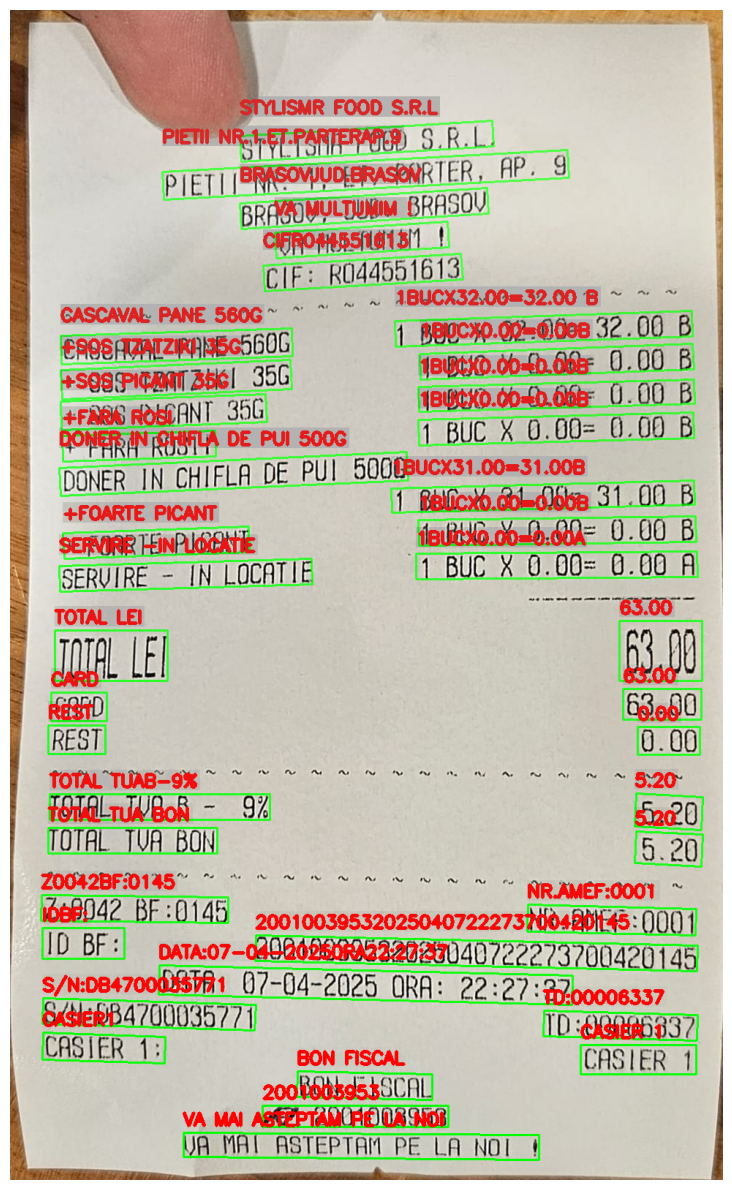

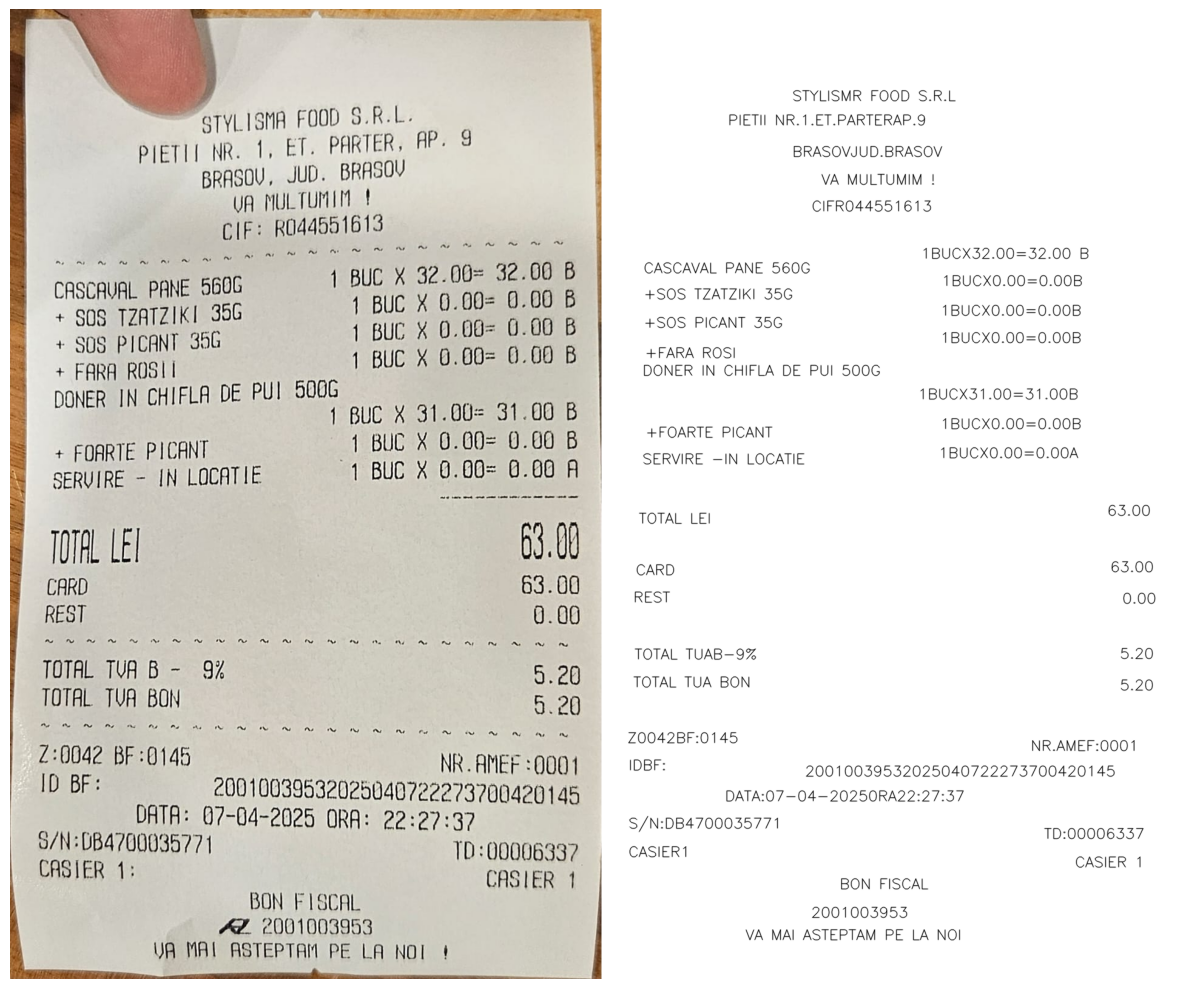

In [5]:
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='en',
    use_gpu=True)

img_path = 'Z:/projects/Receipt-OCR/data/receipt_test_3.jpeg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

# draw result
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result[0]]
txts = [line[1][0] for line in result[0]]

draw_ocr_results(img_path, result, draw_score=False, font_scale=0.8, font_thickness=3, text_box_alpha=0.01)
draw_text_on_blank_side_by_side(
    image_path=img_path,
    ocr_result=result,
    show=True,
)


[2025/04/17 22:00:52] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\test/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\test/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 3

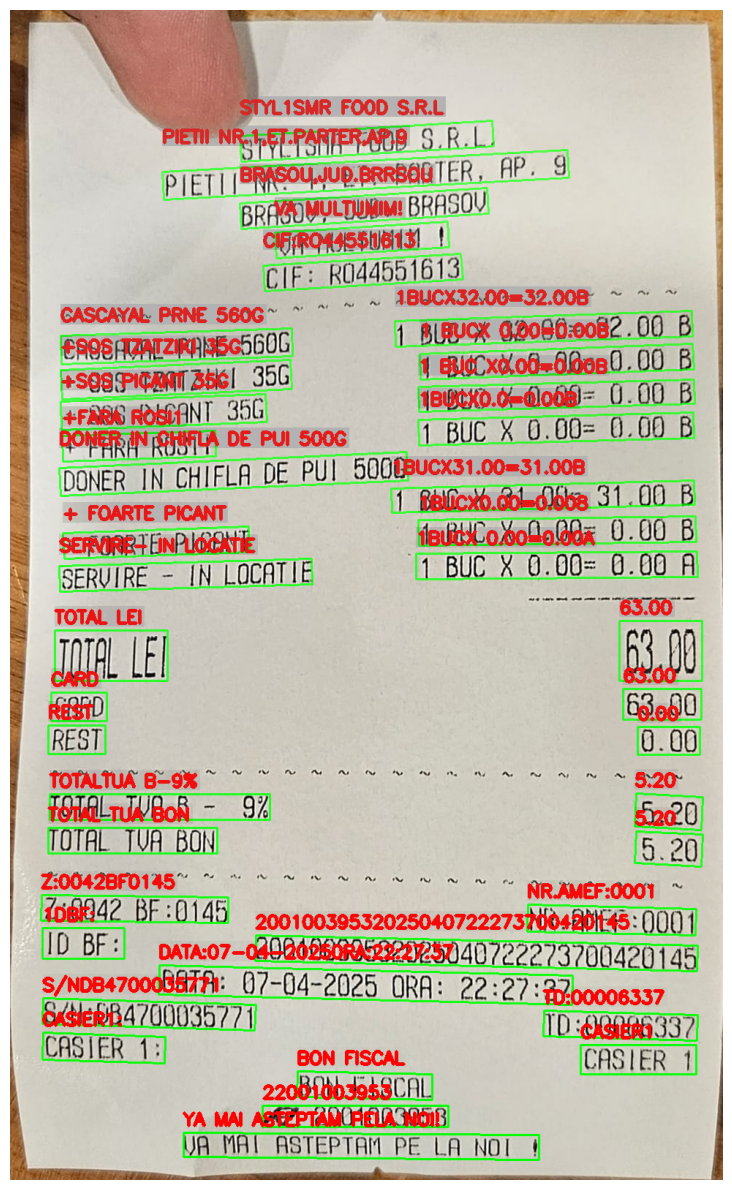

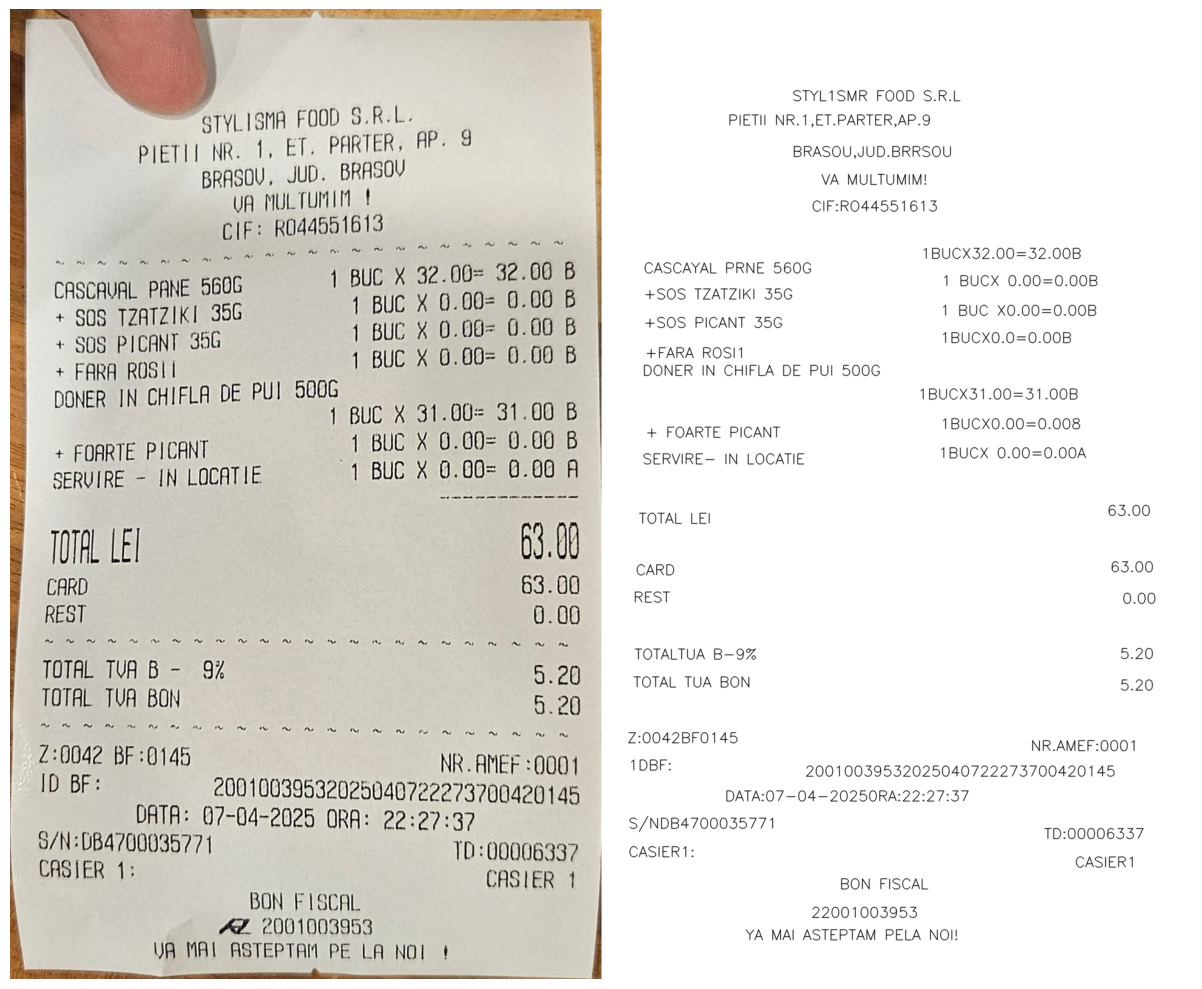

In [6]:
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='ro',
    use_gpu=True)

img_path = 'Z:/projects/Receipt-OCR/data/receipt_test_3.jpeg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

# draw result
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result[0]]
txts = [line[1][0] for line in result[0]]

draw_ocr_results(img_path, result, draw_score=False, font_scale=0.8, font_thickness=3, text_box_alpha=0.01)
draw_text_on_blank_side_by_side(image_path=img_path, ocr_result=result, show=True)

[2025/04/17 22:00:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\test/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\test/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', r

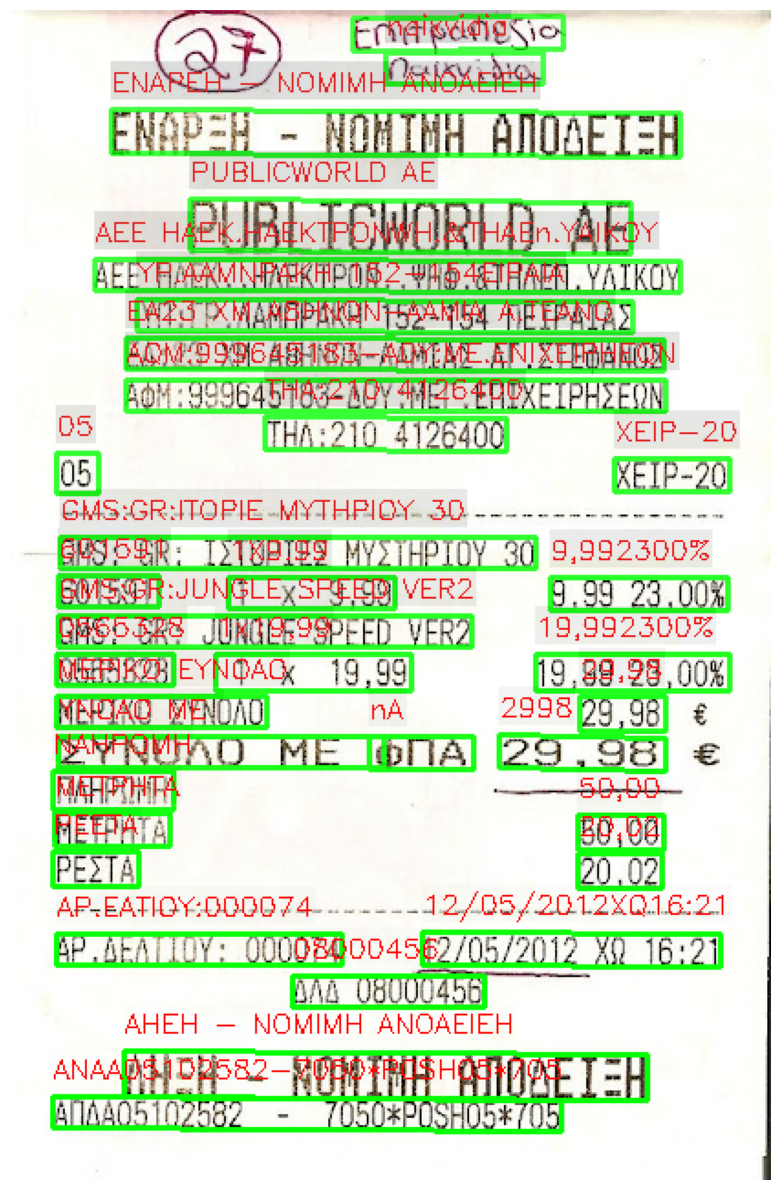

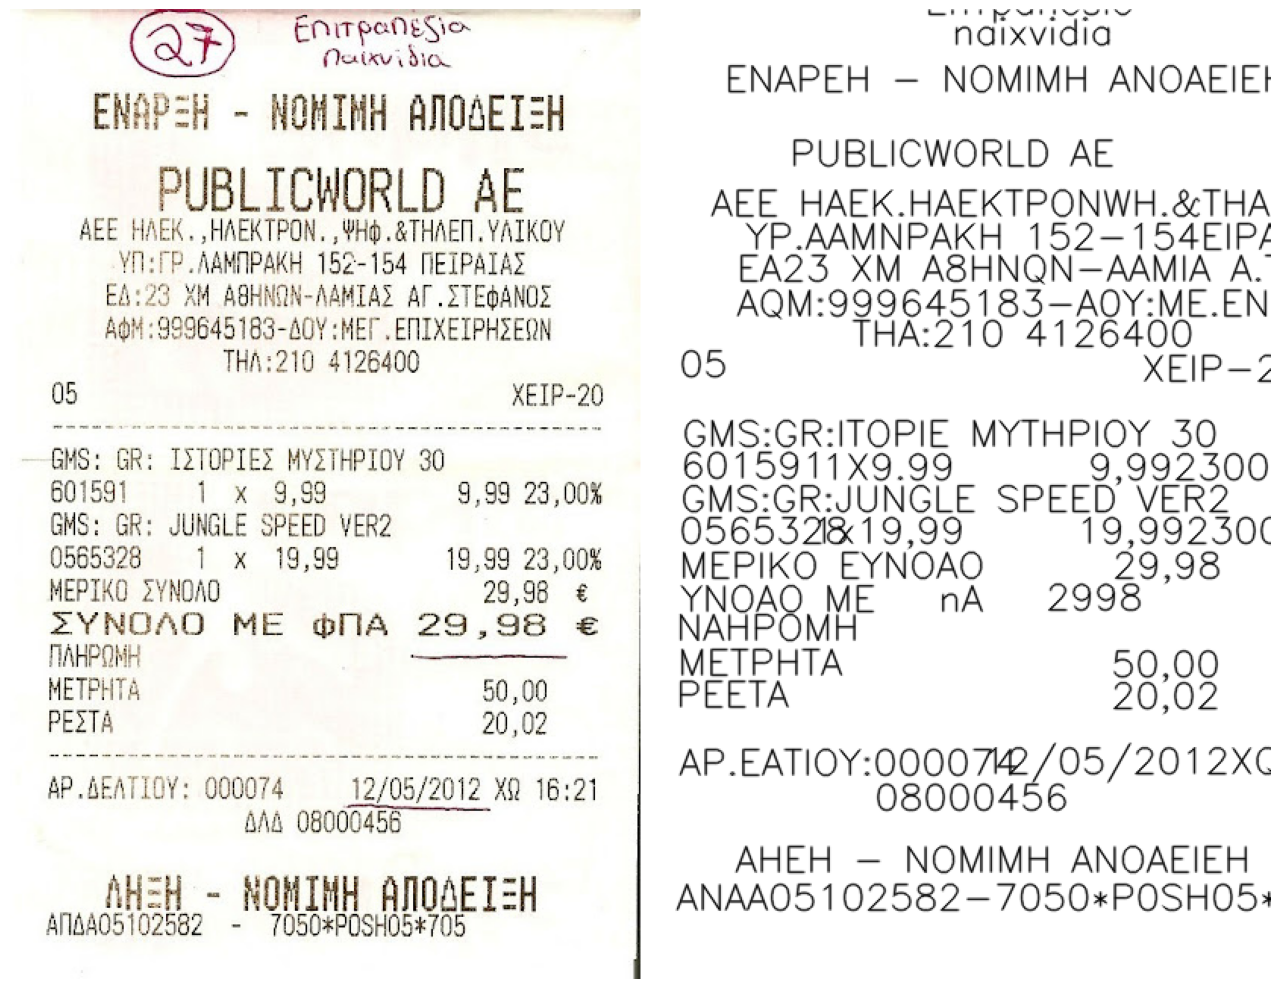

In [7]:
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='en',
    use_gpu=True)

img_path = 'Z:/projects/Receipt-OCR/data/bon_grec.jpg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

# draw result
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result[0]]
txts = [line[1][0] for line in result[0]]

draw_ocr_results(img_path, result, draw_score=False, font_scale=0.5, font_thickness=1, text_box_alpha=0.01)
draw_text_on_blank_side_by_side(image_path=img_path, ocr_result=result, show=True)